# Classification
## MNIST
We will be studying a classification algorithm on the MNIST dataset. The MNIST dataset, contains 70,000 small images of handwritten numbers together with their labels. This is a very famous Machine Learning dataset, one that some people call the "hello world" of machine learning. 

Scikit-Learn offers many helper functions for downloading popular datasets- *MNIST being one of them*. The following code fetches the MNIST dataset.

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False, )
mnist.keys()

/home/keenan/.local/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by Scikit-Learn generally have a similair dictionary structure, including the following:
* A DESCR key describing the dataset.
* A data key cintaining an array with one row per instance and one column paer feature.
* A target key containing an array with the labels.

Let's check out the describe key and look at these arrays:

In [2]:
print(mnist["DESCR"])

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [3]:
X,y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

There are 70,000 images, and each image has 784 features. Each feature is a pixel and the images are 28 pixels by 28 pixels. Features range in value from 0 (white) to 255 (black). Let's take a peak at an instance of our dataset. To view it as an image we need to grab the instance's feature vector, reshape it into a 28 by 28 grid, and display it using matplotlibs imshow() function:

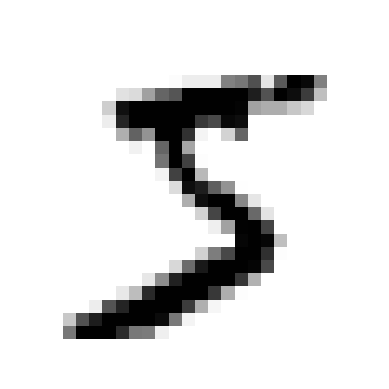

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()

This looks like a 5. We can check the label by calling y[0].

In [5]:
y[0]

'5'

Note that the label is a string. As we've discussed earlier, most Machine Learning algorithms expect numbers, so lets cast y to be an integer:

In [6]:
import numpy as np

y = y.astype(np.uint8)

### Create Train and Test set
Before going any further, we should create our train and test sets. It's a good idea to do this prior to looking at the data or making any changes to it, just to insure we have an untouched copy. The MNIST dataset iss already spliit into a training set and a test set. The classic training set is the first 60,000 instances and the training set the last 10,000. The training set is also already shuffled for us, which is important for cross-validation. Let's split up our test and train set:

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier
Let's simplify the problem for now and only try to identify one digit- *for example, nummber 5*. This "5-detector" is an example of a binary classifier. It only distiguishes two classes, 5 or not-5. Let's create the *target vector* for this classification task.

In [8]:
y_train_5 = (y_train == 5)  # True for all 5's, False otherwise
y_test_5 = (y_test ==5)

Now we need to pick a classifier and train it. A good start is with a Stochastic Gradient Descent (SGD) classifier, we can do this with Scikit-Learn's SGDClassifier class. This classifier is very good at handling large datasets efficiently, in part because it works with one instance at a time. This is very good for live systems.

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now let's test our model on the 5 we viewed earlier. The output of sgd_clf.predict([some_digit]) should be True.

In [10]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures
Evaluating a classifier can be significantly trickier than evaluating a regressor. There are many performance measures available. Let's explore a number of these options:

### Measuring Accuracy Using Cross Validation
A good place to start would be using cross validation, just as we did with the housing price predictor.
#### Implementing Cross-Validation
Occasionally we will need more control over the cross-validation process than what Scikit-Learn provides off the shelf. In these cases, we will need to implement cross validation ourselves. Let's write a function to do roughly the same thing as Scikit-Learn's cross_val_score() function.

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct/len(y_pred))

0.9669
0.91625
0.96785


We might be tempted to get excited about these scores, I mean each fold resulted in an error of less than 10 percent! But remember, only about ten percent of the numbers in our dataset are 5's. If we wrote a dumb classifier that guesses not-5 every single time, we would get an accuracy of 90 percent, i.e. an error of just about 10 percent.

This is all to demonstrate that accuracy is not the preffered performance measure for classifiers, especially those that are dealing with skewed data. Our data here is particularly skewed because the not-5 class appears about nine times as often as the 5 class.
### Confusion Matrix
A much better way to evaluate the data is to build and view a confusion matrix. The general idea is to count how many times an instance of class A is predicted to be an element of class B. For example: how many times was an instance from class 5 confused with an instance of class 3? To find the answer to this question, we would check the fifth row and third column of the confusion matrix.

To compute the confusion matrix, we can use the cross_val_predict() function. Just like cross_val_scores(), cross_val_predict() performs a K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. After training with cross_val_predict, we can get the confusion matrix with sklearn.metric's confusion_matrix() function, all we have to do is pass it the target class and the predicted classes.

In [12]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each row in the confussion matrix represents an *actual class* and each column a *predicted class*. Element $a_{11}$ represents non-5's that were classified as non-5's (true negatives) and element $a_{21}$ represents non-5's that were classified as a 5 (false positives). On the other hand, element $a_{12}$ represents the number of 5's classified as non-5's (false negatives) and element $a_{22}$ 5's classified as 5's (true positives). A perfect classifiers confusion matrix would only have non-zero numbers on the diagonal.

The confusion matrix gives us a lot of information, but sometimes a more concise metric is prefered. An interesting one is called *precision*, the accuracy of the positive predictions:
$$
precision = \frac{TP}{TP + FP}
$$
where TP is the number of true positives and FP the number of false positives. It is common, however, for precision to be used together with another metric called *recall* (a.k.a. *sensitivity*, *true positive rate (TPR)*), the ratio ratio of positive instances that are correctly detected by the classifier.
$$
recall = \frac{TP}{TP + FN}
$$
where TP is defined as obove and FN is the number of false negatives.
### Precision and Recall
Scifit-Learn provides several functions to compute classifier metrics,  including precision and recall:

In [13]:
from sklearn.metrics import precision_score, recall_score
print("PRECISION:", precision_score(y_train_5, y_train_pred))
print("RECALL:", recall_score(y_train_5, y_train_pred))

PRECISION: 0.8370879772350012
RECALL: 0.6511713705958311


Now our 5 detector doesn't look so good. When it claims an image represents a 5, it's right 83 percent of the time, which is good, but it only detects 65 percent of the 5's. In other words, it classifies 83 percent of 65 percent of the fives correctly, this is about as good as random guessing. 

It is often convenient to combine the precision and recall into a single metric called the $F_1 score$. It is especially useful when you need to compare two classifiers. The $F_1 score$ is the *harmonic mean* of precision and recall. The harmonic mean is different from the mean in that it gives much higher weight to low values. As a result the $F_1 score$ is only high if both precision and recall are high.
$$
F_1 = \frac{2}{\frac{1}{precision}+\frac{1}{recall}} = \frac{TP}{TP + \frac{FN + FP}{2}}
$$
To compute the $F_1 score$, we simply call sklearn.metrics f1_score function as  follows:

In [14]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

The $F_1 score$ favors classifiers with similair precision and recall. This is not always what you want though. Suppose we built a model that detects videos that are safe for kids. We would prefer a classifier that rejects many good videos (low recall) but lets  few very bad videos through (high precision). On the other hand, if we wanted to fdetect shop lifters, we might be okay with low precision, many non shop lifters get classified as shop lifters, but high precision. Meaning that all true shoplifters are classified as shop lifters.

So how do we decide what threshold to use (the trade ooff between precision/recall)? First, we need to use cross_val_predict() to get the scores of all instances in the training set, but this time we should specify that we want to geet back decision scores instead of predictions. With these scores, we can use the precision_recall_curve() function to compute precision and recall for all possible thresholds:

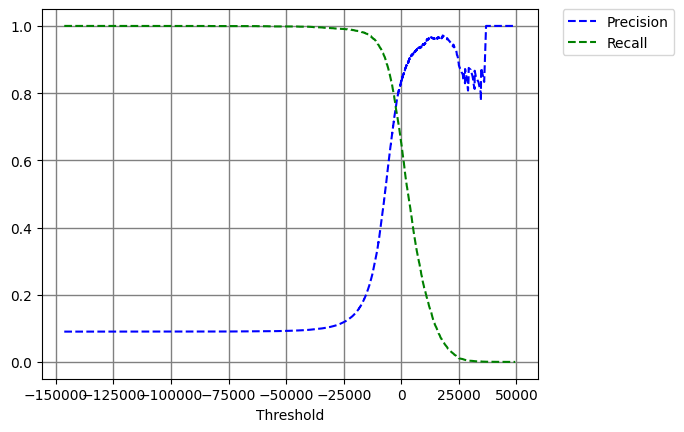

In [15]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_thresholds(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(which="both", axis="both", color='gray', linestyle='-', linewidth=1)

plot_precision_recall_vs_thresholds(precisions, recalls, thresholds)
plt.show()

Another good way to select a good precision/recall is by plotting precision and recall against eachother. If we see a sharp decline on the graph, we might want to choose a precision that occurs shortly before that drop. Let's examine the following and choose a recall:

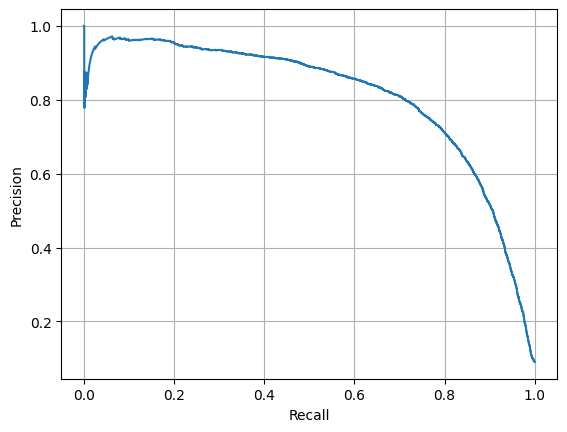

In [16]:
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(which="both", axis="both", visible=True)

Perhaps a recall of around 60 percent would do us well.
### The Receiver Operating Characteristic (ROC) Curve
The *receiver operating characteristic* is another common tool used with binary classifiers. THE ROC curve is similair to the precision-recall-curve, but instaed of plotting precision and recall, it plots tthe *true positive rate* (recall) against the *false positive rate* (FPR). The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to:
$$
FPR = 1 - TNR
$$
where TNR stands for the *true negative rate*, the number of negative instances that were correctly classsified.

To plot the ROC curve, we need to use the roc_curve() function to compute the TPR and FPR for various threshold values. Then, we can plot the FPR against the TPR using MatPlotlib:

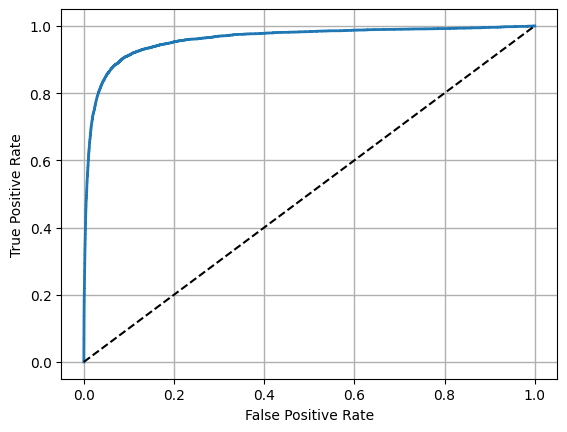

In [17]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')  # dashed diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(visible=True, which="both", linewidth=1)

plot_roc_curve(fpr, tpr)
plt.show()

Once again there is a trade  off: the higher the recall (TPR), the more false positives the classifier produces. The dotted line represents the ROC curve of a truely random classifier; a good classifier is far away from that line,, toward the top left corner.

One way to compare classifiers is to measure the *area under the curve (AUC)*, a perfect classifier will have an AUC of 1, whereas a purely random classifier will have an ROC AUC of 0.5. Scikit-Learn provides a function for computing the ROC AUC: 

In [18]:
from sklearn.metrics import roc_auc_score


roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Let's now train a RandomForestClassifier and compare its ROC curve and ROC AUC score to that of the StochasticGradientDescent classifier. First, we need to get scores for each instance in the training set. Note: the RandomForestClassifier does not have a decision function, instead it hhas a predict_proba() method. Scokit-Learn classifiers generally have one or the other and sometimes both. The predict_proba() method returns an array containing a row per instance and a column per class, each containing the probability that the instance belongs to that class. The roc_curve() function expects labels and scores, but instead we can give it class probabilities. Let's use the positive class probabilities as the score and plot the ROC curve:

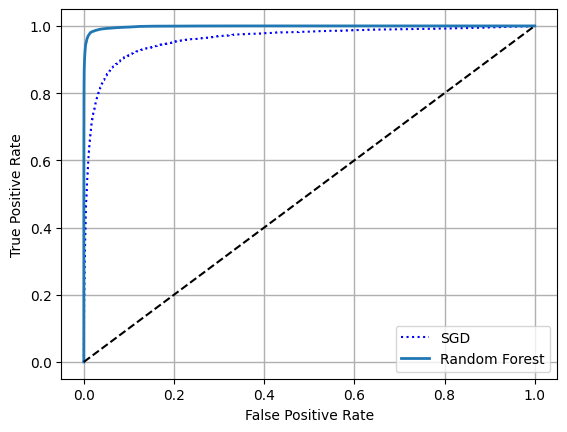

In [19]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:,1]  # scores = proba of positive class
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

Wow! the Random Forest Classifier does much better, look how tight that curve is in the top  right hand corner. Remember the ROC AUC of the Stochastic Gradient Descent Classifier was just over 0.96, lets find the area under the curve for our Random Forest Classifier:

In [20]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## Multiclass Classification
Whereas binary classifiers distinguish between two classes, *multiclass classifiers* distinguish between more than two classes. Some algorithms such as Logistic Regression, Random Forestm and Naive Bayes classifiers are capable of handling many classes natively. Others such as Stochastic Gradient Descent or Support Vector Machine classifiers are strictly binary classifiers.

If we want to do multiclass classsification with a binary classifier, we have to come up with a clever scheme. One clever scheme is called one versus the rest (OVR), this is essentially what we started with the 5 classisifer. If we had one of these for all digits, we could stick with the prediction that has the highest probability of being correct. Another potential idea is the one versus one approach, where we'd have 45 different classifiers choosing between one of two potential numbers then taking a kind of voting scheme choose the most likely number.

Scikit-Learn detects when you try to use a binary classifier on a multiclass problem, then implements an OVR or OVO scheme automatically. Let's give this a try with the MNIST dataset:

In [21]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

It predicted correctly! Training a Stochastic Gradient Descent classifier would be just as easy. Lets give that a try and then print the decision function values to see how convinced it is that some_digit is a five.

In [22]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

Interesting, it got it wrong. Let's  use the decision_function() method to see what values it assigned to each number. The higher the better.

In [23]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

It appears the classifiers second guess would have been 5, but it was fairly certain that the digit was a 3. Let's see how the rest of this model is performing by finding thhe cross-validation scores.

In [24]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

Even though it scored our sample digit wrong, it has scored over 85 percent on the larger data. This is a lot better than the 10 percent accuracy we would expect with random guessing. We can however do better. In fact we might be able to expect an accuracy around 90 percent as simply by scaling the input data.

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis
If this were a real project, we'd follow the steps in the Machine Learning checklist. We'd explore some data preparation options, try out multiple models (shortliisting the best ones and fine tuning their hyperparameters), and automate as much as possible. Let's assume we've found a good model and are now looking for ways to improve it. To do this, we could start by analyzing where it makes mistakes.

First, lets look at the confusion matrix. We will need to make predictions using cross_val_predict, then call the confusion_matrix() function. Just like we had done earlier:

In [26]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

This matrix contains a lot of numbers and is kind of overwhelming. Perhaps it would be better to represent this matrix as an image using Matplotlib's matshow() function:

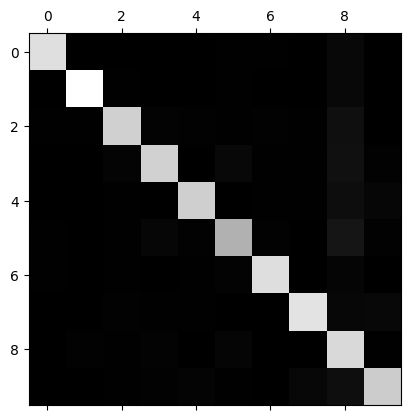

In [27]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

This confusion matrix looks pretty good,, since most of the light squares are on tthe main diagnol meaning they were classified correctly. The 5's look slightly darker than the rest of the squares, which might meaan there are less 5's in the dataset or that the classifier is not performing well on the 5's.

Let's focus the plot on errors. First, we need to divide each number in the confusion matrix by the number of images in the corresponding class. This allows us to compare error rates, rather than absolute number of errors. We should also fill the diagonal with 0's to keep only the error rates.

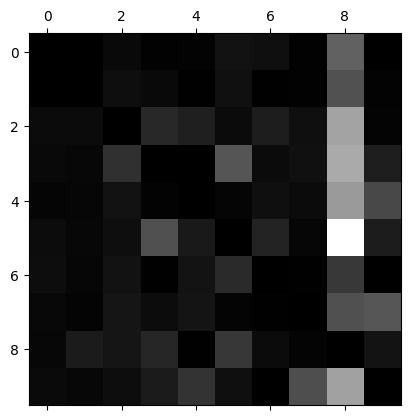

In [29]:
row_sum = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sum

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

We can clearly see the kinds of errors the classifier is making. Remember that rows represent actual classes and columns predited classes. We can see that many of the classes are being incorrectly classified as 8's. However, 8's themselves are being classified pretty well. We can also see that 3's and 5's get mixed up fairly often in both directions.

Looking at this confusion matrix, we learn that we should spend some time on reducing false 8's. Maybe we could find more data of images that look like 8's, but are not. We could also engineer some new features, like number of closed loops (8's have 2 closed loopsn and 6's only 1). We could also use Scikit-Learn, Pillow, or OpenCV to do some imaage preprocessing which might make the closed loops stand out more.
## Multilabel Classification
Until now each instance has only been assigned to one class. In some cases you may want your classifier to output multiple classes for each instance. Consider a face-recognition classifier: what should it do if it recognizes several people in the same picture? It should attach one tag for each person iit recognizes. Say the classifier has been trained to recognize the faces of Alice, Charlie, and Bob. If Alice and Bob are in frame, it should output [1, 0, 1] meaning Alice "yes", Charlie "no", Bob "yes". Such a system that outputs multiple binary tags is called a *multilabel classification* system.

We won't go into facial recognition right now, but let's look at a simpler example:

In [30]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train%2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

This code creates a y_multilabel array containing two target labels for each digital image. The first indicates whether or not the digit is large (7, 8, and 9), and the second indicates whether or not it is odd. The next line creates a KNearestNeighbors classifier- *which is one of the classifiers that can do multilabel classification*. Then we train it with the multilabel array. Let's see how it does on our example number:

In [31]:
knn_clf.predict([some_digit])

array([[False,  True]])

And it gets it right. The digit, 5, is not large (False) and it is odd (True). 
## Multioutput Classification
The last type of classification task that we want to discuss here is called *multioutput-multiclass classification* or just *multioutput classification*. It is a generalization of multilabel classification in which each label can be multiclass (i.e. it can have more than two possible values).

To illustrate this, lets make a system that removes noise from an image. It will take a noisy image and hopefully output a clean digital image, representing an array of pixel intensities. Notice, that the classifier's output is multilabel (one label per pixel) and each label can have multiple values (pixel intensities range from 0 to 255). It is thus an example of a multioutput classification system.

Let's start by creating the training and testing set by taking the MNIST imagess and adding noise to them using NumPy's randint() function. The target images will be the original images:

In [33]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Let's take a peak at an image from the test set (yes, we're snooping the test set so you should be frowning):

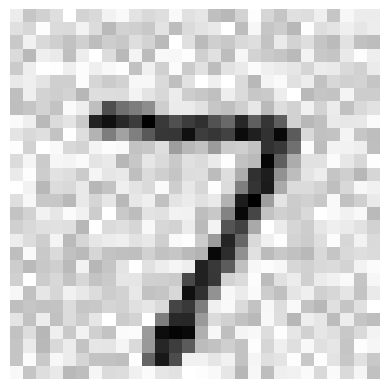

In [37]:
some_digit = X_test_mod[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()

This is very noisy. Let's train the classifier and make it clean this image.

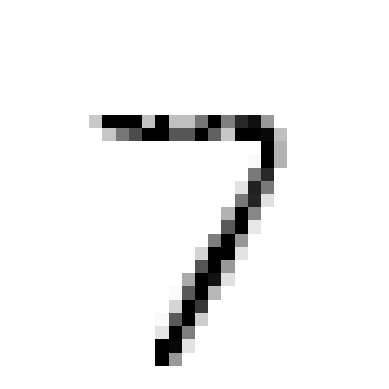

In [36]:
knn_clf.fit(X_train_mod, y_train_mod)

clean_digit = knn_clf.predict([X_test_mod[0]])
clean_digit_image = clean_digit.reshape(28, 28)

plt.imshow(clean_digit_image, cmap='binary')
plt.axis("off")
plt.show()

Looks pretty good! This concludes our tour of classification. We should now know how to select good metrics for classification tasks, pick the appropriat precision/recall point, commpare classifiers, and accomplish a number of different classification tasks.